# Best Location to Open a Halal Restaurant in Toronto

### Applied Data Science Capstone Project by IBM/Coursera

## Table of Contents <a name="toc"></a>

1. [Introduction: Business Problem](#introduction)
2. [Data](#data)
3. [Methodology](#methodology)
4. [Data Analysis & Machine Learning](#analysis)
5. [Results](#results)
6. [Discussion](#discussion)
7. [Conclusion](#conclusion)

## 1. Introduction: Business Problem <a name="introduction"></a>

A client from Turkey wants to open his chain restaurant in Toronto. The restaurant will focus on serving halal food option to cater to Muslims around a neighbourhood that lacks this service. Setting up a business can be challenging at a location that is foreign to a business owner. Therefore, the client requires assistance to find the best borough/neighbourhood in Toronto to open a Halal Restaurant. 

The challenge to find a strategic neighbourhood is to ensure the following criteria are taken into consideration as well:

1. Where the targeted customer is most clustered at. (in this case, we will choose Mosque venue as the key factor to assume the target market cluster for a halal restaurant).
2.	Little to no competition would help to reduce risk and gain a reasonable return on investment.
3.	The availability of suppliers such as farmers market, wholesale market to purchase fresh ingredients to ensure quality and cost-effectiveness.



[Scroll back to Table of Contents](#toc)

## 2. Data <a name="data"></a>

For this project we need the following data:
1.	Toronto dataset that contains list of Boroughs, Neighborhoods along with their latitude and longitude.

    *	Data source:https://en.wikipedia.org/w/index.php?title=List_of_postal_codes_of_Canada:_M&oldid=945633050
    *	Data usage: To explore various Boroughs and Neighborhoods of Toronto.

2.	Mosques in each Boroughs of Toronto.

    *	Data source: Foursquare API
    *	Data usage: Identifying Mosques location can help justify where most Muslims are clustered at, as Muslims frequently gather at or visit a mosque.

3.	Halal restaurants nearby the mosques.

    *	Data source: Foursquare API 
    *	Data usage: Identifying competitions and which Borough/Neighborhood lacking halal service option.

4.	Farmers Markets, Supermarkets, Fish Markets, etc

    *	Data source: Foursquare API 
    *	Data usage: To identify which location will be the strategically near to get fresh supplies and other stocks.


[Scroll back to Table of Contents](#toc)

## 3. Methodology <a name="methodology"></a>

Import Libraries.

In [1]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import urllib.request # library to open URLs

!pip -q install bs4
from bs4 import BeautifulSoup # import the BeautifulSoup library so we can parse HTML and XML documents

import json # library to handle JSON files

!pip -q install geopy #install geopy
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
#RateLimiter, class which can be used to automatically add delays between geocoding calls to reduce the load on the Geocoding service. 
#Also it can retry failed requests and swallow errors for individual rows.
from geopy.extra.rate_limiter import RateLimiter 

import requests # library to handle requests

!pip -q install folium #install folium
import folium # map rendering library

import matplotlib.cm as cm # Matplotlib and associated plotting modules
import matplotlib.colors as colors # Matplotlib and associated plotting modules

from collections import Counter # count occurrences 

# import k-means from clustering stage
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

print('Libraries imported.')

Libraries imported.


### Get Toronto Dataset

#### Scrape Toronto Data from Wikipedia page.

In [2]:
# specify the URL/web page we are going to be scraping
url = "https://en.wikipedia.org/w/index.php?title=List_of_postal_codes_of_Canada:_M&oldid=945633050"
# open the url using urllib.request and put the HTML into the page variable
page = urllib.request.urlopen(url)
# parse the HTML from our URL into the BeautifulSoup parse tree format
soup = BeautifulSoup(page)
print('Soup ready!')

Soup ready!


In [3]:
# analyse the HTML underlying the website
#print(soup.prettify())

In [4]:
# use the 'find_all' function to bring back all instances of the 'table' tag in the HTML and store in 'all_tables' variable
all_tables=soup.find_all("table")
#all_tables

In [5]:
right_table=soup.find('table', class_='wikitable sortable')
#right_table

# Loop through the rows

A=[]
B=[]
C=[]

for row in right_table.findAll('tr'):
    cells=row.findAll('td')
    if len(cells)==3:
        A.append(cells[0].find(text=True))
        B.append(cells[1].find(text=True))
        C.append(cells[2].find(text=True))

In [6]:
#convert list to dataframe
df=pd.DataFrame(A,columns=['PostalCode'])
df['Borough']=B
df['Neighborhood']=C
df.head()

,PostalCode,Borough,Neighborhood
0,M1A,Not assigned,Not assigned
1,M2A,Not assigned,Not assigned
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,Harbourfront


#### Explore Dataset and Data Cleaning.

In [7]:
print('Dataframe shape {}'.format(df.shape))
df.info()

Dataframe shape (287, 3)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 287 entries, 0 to 286
Data columns (total 3 columns):
PostalCode      287 non-null object
Borough         287 non-null object
Neighborhood    287 non-null object
dtypes: object(3)
memory usage: 6.8+ KB


In [8]:
print('Total Boroughs {}'.format(df['Borough'].drop_duplicates().reset_index(drop=True).count()))
df["Borough"].value_counts()

Total Boroughs 11


Not assigned        77
Etobicoke           45
North York          38
Downtown Toronto    37
Scarborough         37
Central Toronto     17
West Toronto        13
York                 9
East Toronto         7
East York            6
Mississauga          1
Name: Borough, dtype: int64

In [9]:
#Remove 'PostalCode' column.
df = df.drop(['PostalCode'],axis=1)

#Remove rows with Borough equals to 'Not assigned' and 'mississuaga'.
df = df[(df.Borough != 'Mississauga') & (df.Borough != 'Not assigned')].reset_index(drop=True)

print('Total Borough {}'.format(df['Borough'].drop_duplicates().reset_index(drop=True).count()))
print('Total Neighborhood {}'.format(df['Neighborhood'].count()))
print('Dataframe shape {}'.format(df.shape))
df.head()

Total Borough 9
Total Neighborhood 209
Dataframe shape (209, 2)


,Borough,Neighborhood
0,North York,Parkwoods
1,North York,Victoria Village
2,Downtown Toronto,Harbourfront
3,North York,Lawrence Heights
4,North York,Lawrence Manor


#### Get Neighborhood Latitude and Longitude using Geopy.

In [10]:
geolocator = Nominatim(user_agent="tor_explorer")
geocode = RateLimiter(geolocator.geocode, min_delay_seconds=1)

# create empty lists
list_lat = []   
list_lng = []

for index, row in df.iterrows(): # iterate over rows in dataframe

    Neighborhood = row['Neighborhood']
    City = 'Toronto'     
    address = str(Neighborhood)+', '+ City
    #print(address)

    #location = geolocator.geocode(address)
    location = geocode(address)
    if location is None :
        lat = None
        lng = None
    else:
        lat = location.latitude
        lng = location.longitude
    #print('{},{}'.format(lat,lng))

    list_lat.append(lat)
    list_lng.append(lng)

# create new columns from lists    
df['Latitude'] = list_lat   
df['Longitude'] = list_lng

print('Dataframe shape {}'.format(df.shape))
df.head()

Dataframe shape (209, 4)


,Borough,Neighborhood,Latitude,Longitude
0,North York,Parkwoods,43.758800,-79.320197
1,North York,Victoria Village,43.732658,-79.311189
2,Downtown Toronto,Harbourfront,43.640080,-79.380150
3,North York,Lawrence Heights,43.722778,-79.450933
4,North York,Lawrence Manor,43.722079,-79.437507


In [11]:
#remove rows with NaN values
toronto_data = df.dropna().reset_index(drop=True)
print('Dataframe shape {}'.format(toronto_data.shape))
toronto_data.head()

Dataframe shape (201, 4)


,Borough,Neighborhood,Latitude,Longitude
0,North York,Parkwoods,43.758800,-79.320197
1,North York,Victoria Village,43.732658,-79.311189
2,Downtown Toronto,Harbourfront,43.640080,-79.380150
3,North York,Lawrence Heights,43.722778,-79.450933
4,North York,Lawrence Manor,43.722079,-79.437507


In [12]:
print('The dataframe has {} boroughs and {} neighborhoods.'.format(
        len(toronto_data['Borough'].unique()),
        toronto_data.shape[0]
    )
)

The dataframe has 9 boroughs and 201 neighborhoods.


#### Use geopy library to get the latitude and longitude values of Toronto City.

In [13]:
address = 'Toronto, CA'
location = None

# define an instance of the geocoder -> tor_explorer
while location == None:
    try:
        geolocator = Nominatim(user_agent="tor_explorer")
        location = geolocator.geocode(address)
        latitude = location.latitude
        longitude = location.longitude
    except:
        pass
print('The geograpical coordinate of Toronto are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Toronto are 43.6534817, -79.3839347.


In [14]:
# create map of Toronto using latitude and longitude values
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(toronto_data['Latitude'], toronto_data['Longitude'], toronto_data['Borough'], toronto_data['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
map_toronto

#### Explore Toronto Neighborhood 

In [15]:
# The code was removed by Watson Studio for sharing.

#### Explore the first neighborhood to understand the results of GET request

In [16]:
toronto_data.loc[0, 'Neighborhood']

'Parkwoods'

Get Parkwoods' latitude and longitude values.

In [17]:
neighborhood_latitude = toronto_data.loc[0, 'Latitude'] # neighborhood latitude value
neighborhood_longitude = toronto_data.loc[0, 'Longitude'] # neighborhood longitude value
neighborhood_name = toronto_data.loc[0, 'Neighborhood'] # neighborhood name

print('Latitude and longitude values of {} are {}, {}.'.format(neighborhood_name, 
                                                               neighborhood_latitude, 
                                                               neighborhood_longitude))

Latitude and longitude values of Parkwoods are 43.7587999, -79.3201966.


Get the required venue category that is in Parkwoods within 500 meters.

In [18]:
LIMIT = 3 # limit of number of venues returned by Foursquare API
radius = 500 # define radius
categoryId = ['4bf58dd8d48988d138941735', # category ID required for Mosque
              '52e81612bcbc57f1066b79ff', # category ID required for Halal Restaurant
              '4bf58dd8d48988d1fa941735','4bf58dd8d48988d10e951735','52f2ab2ebcbc57f1066b8b1c','52f2ab2ebcbc57f1066b8b46'] # category ID required for Market
url = []
# create URL
for data in categoryId :
    url.append(('https://api.foursquare.com/v2/venues/search?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&categoryId={}&limit={}'.format(
        CLIENT_ID, 
        CLIENT_SECRET, 
        VERSION, 
        neighborhood_latitude, 
        neighborhood_longitude, 
        radius,
        data,
        LIMIT))) 

categoryId = categoryId[+1:+1]   
url # display URL

['https://api.foursquare.com/v2/venues/search?&client_id=CXOP2GJYWTVV2JCPAWWRYKSYBLYQXG4KFAYLOQSHZDTP54KN&client_secret=4CJHJO1SBF4LOAPCYIIMQ44YKHKMOZIYMCGB3IAMPB20LSIQ&v=20180605&ll=43.7587999,-79.3201966&radius=500&categoryId=4bf58dd8d48988d138941735&limit=3',
 'https://api.foursquare.com/v2/venues/search?&client_id=CXOP2GJYWTVV2JCPAWWRYKSYBLYQXG4KFAYLOQSHZDTP54KN&client_secret=4CJHJO1SBF4LOAPCYIIMQ44YKHKMOZIYMCGB3IAMPB20LSIQ&v=20180605&ll=43.7587999,-79.3201966&radius=500&categoryId=52e81612bcbc57f1066b79ff&limit=3',
 'https://api.foursquare.com/v2/venues/search?&client_id=CXOP2GJYWTVV2JCPAWWRYKSYBLYQXG4KFAYLOQSHZDTP54KN&client_secret=4CJHJO1SBF4LOAPCYIIMQ44YKHKMOZIYMCGB3IAMPB20LSIQ&v=20180605&ll=43.7587999,-79.3201966&radius=500&categoryId=4bf58dd8d48988d1fa941735&limit=3',
 'https://api.foursquare.com/v2/venues/search?&client_id=CXOP2GJYWTVV2JCPAWWRYKSYBLYQXG4KFAYLOQSHZDTP54KN&client_secret=4CJHJO1SBF4LOAPCYIIMQ44YKHKMOZIYMCGB3IAMPB20LSIQ&v=20180605&ll=43.7587999,-79.3201966&radiu

Send the GET request and examine the results

In [19]:
results = []
for link in url:
    results.append(requests.get(link).json()) 
url=url[+1:+1]

In [20]:
for i in range(len(results)) :
    print(results[i]['response']['venues'])

[]
[]
[]
[]
[]
[{'id': '4b26adc3f964a5205f7f24e3', 'name': 'Food Basics', 'location': {'address': '1277 York Mills Rd', 'crossStreet': 'at Parkwoods Village Dr.', 'lat': 43.76054899113784, 'lng': -79.32604520023006, 'labeledLatLngs': [{'label': 'display', 'lat': 43.76054899113784, 'lng': -79.32604520023006}], 'distance': 508, 'postalCode': 'M3A 1Z5', 'cc': 'CA', 'neighborhood': 'Parkwoods - Donalda', 'city': 'Toronto', 'state': 'ON', 'country': 'Canada', 'formattedAddress': ['1277 York Mills Rd (at Parkwoods Village Dr.)', 'Toronto ON M3A 1Z5', 'Canada']}, 'categories': [{'id': '52f2ab2ebcbc57f1066b8b46', 'name': 'Supermarket', 'pluralName': 'Supermarkets', 'shortName': 'Supermarket', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/shops/food_grocery_', 'suffix': '.png'}, 'primary': True}], 'referralId': 'v-1589091097', 'hasPerk': False}, {'id': '4bc603bf6c26b7135125ecf3', 'name': 'Metro', 'location': {'address': '15 Ellesmere Rd', 'crossStreet': 'at Parkway Mall', 'lat': 43

##### The aim for this project is to segment the neighborhoods of Toronto with respect to Mosques, markets and halal restaurants.

Next is to get data from all the 201 neighborhood's venues.

In [21]:
def getNearbyVenues(names, latitudes, longitudes, radius=1000, LIMIT=500):
    not_found = 0
    print('***Start ', end='')
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(' .', end='')
        
        categoryId = ['4bf58dd8d48988d138941735', # category ID required for Mosque
                      '52e81612bcbc57f1066b79ff', # category ID required for Halal Restaurant
                      '4bf58dd8d48988d1fa941735','4bf58dd8d48988d10e951735','52f2ab2ebcbc57f1066b8b1c','52f2ab2ebcbc57f1066b8b46'] # category ID required for Market
        
        for i in categoryId :
            # create the API request URL
            url = 'https://api.foursquare.com/v2/venues/search?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&categoryId={}&limit={}'.format(
                CLIENT_ID, 
                CLIENT_SECRET, 
                VERSION, 
                lat, 
                lng, 
                radius,
                i, 
                LIMIT)
            
            try:
                # make the GET request
                results = requests.get(url).json()['response']['venues']
            
                # return only relevant information for each nearby venue
                venues_list.append([(
                    name, 
                    lat, 
                    lng, 
                    v['name'], 
                    v['location']['lat'], 
                    v['location']['lng'],  
                    v['categories'][0]['name']) for v in results])
            except:
                not_found += 1
                
        categoryId = categoryId[+1:+1]


    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    print("\nDone*** with {} venues with incompelete information.".format(not_found))
    return(nearby_venues)

In [22]:
tor_venues = getNearbyVenues(names=toronto_data['Neighborhood'],
                                        latitudes=toronto_data['Latitude'],
                                        longitudes=toronto_data['Longitude']
                                       )

***Start  . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Done*** with 0 venues with incompelete information.


[Scroll back to Table of Contents](#toc)

## 4. Data Analysis & Machine Learning <a name="analysis"></a>

Check the tor_venues dataframe shape

In [23]:
print(tor_venues.shape)
tor_venues.head(10)

(1616, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Parkwoods,43.758800,-79.320197,Food Basics,43.760549,-79.326045,Supermarket
1,Parkwoods,43.758800,-79.320197,Metro,43.756643,-79.313639,Supermarket
2,Victoria Village,43.732658,-79.311189,Al Ansar İslamic Centre,43.738526,-79.320284,Mosque
3,Victoria Village,43.732658,-79.311189,Adam's Halal Pub,43.736584,-79.308075,Halal Restaurant
4,Harbourfront,43.640080,-79.380150,Warerfront Artisan Market,43.638320,-79.388133,Farmers Market
5,Harbourfront,43.640080,-79.380150,Family Foods,43.646726,-79.372442,Farmers Market
6,Harbourfront,43.640080,-79.380150,Autum Market - Indoor Farmer Market,43.647636,-79.384113,Farmers Market
7,Harbourfront,43.640080,-79.380150,Farmers MRKT,43.647038,-79.379798,Farmers Market
8,Harbourfront,43.640080,-79.380150,Metro Hall Farmer's Market,43.645920,-79.387507,Farmers Market
9,Harbourfront,43.640080,-79.380150,Longo's Maple Leaf Square,43.642517,-79.381393,Supermarket


Let's find out how many unique categories from the returned venues.

In [24]:
print('There are {} uniques categories.'.format(len(tor_venues['Venue Category'].unique())))
tor_venues.groupby('Venue Category')['Venue Category'].count().sort_values(ascending=False)

There are 24 uniques categories.


Venue Category
Farmers Market               456
Grocery Store                329
Supermarket                  243
Mosque                       142
Fish Market                  122
Fruit & Vegetable Store      112
Halal Restaurant             101
Middle Eastern Restaurant     31
Comfort Food Restaurant       19
Market                        17
Big Box Store                 15
Afghan Restaurant              6
Pizza Place                    6
Food Court                     5
Seafood Restaurant             2
Chinese Restaurant             2
Kebab Restaurant               1
Pakistani Restaurant           1
Flea Market                    1
Park                           1
Dessert Shop                   1
Burger Joint                   1
Steakhouse                     1
Turkish Restaurant             1
Name: Venue Category, dtype: int64

To focus on the aim of this project in exploring the neighborhood, generalized categories need to be removed, like Dessert Shop, Food Court, etc.

In [25]:
# list all the categories
unique_categories = tor_venues['Venue Category'].unique().tolist()
print(', '.join(str(x) for x in unique_categories))

Supermarket, Mosque, Halal Restaurant, Farmers Market, Grocery Store, Middle Eastern Restaurant, Comfort Food Restaurant, Fish Market, Fruit & Vegetable Store, Market, Big Box Store, Pizza Place, Chinese Restaurant, Burger Joint, Park, Afghan Restaurant, Dessert Shop, Kebab Restaurant, Turkish Restaurant, Pakistani Restaurant, Seafood Restaurant, Flea Market, Food Court, Steakhouse


In [26]:
# manually create a list of generalized categories
general_categories = ['Grocery Store', 'Middle Eastern Restaurant',
                      'Comfort Food Restaurant', 'Market', 'Big Box Store',
                      'Pizza Place', 'Chinese Restaurant', 'Burger Joint',
                      'Park', 'Afghan Restaurant', 'Dessert Shop',
                      'Kebab Restaurant', 'Turkish Restaurant',
                      'Pakistani Restaurant', 'Seafood Restaurant',
                      'Flea Market', 'Food Court', 'Steakhouse']

In [27]:
# fetch all the required categories
required_categories =  list(set(unique_categories) - set(general_categories))
print(', '.join(str(x) for x in required_categories))

Fish Market, Supermarket, Mosque, Farmers Market, Halal Restaurant, Fruit & Vegetable Store


Remove all the general categories like  Dessert Shop, Cafe, etc.

In [28]:
tor_venues = tor_venues[tor_venues['Venue Category'].isin(required_categories)].reset_index()
print(tor_venues.shape)
tor_venues.head(5)

(1176, 8)


,index,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,0,Parkwoods,43.758800,-79.320197,Food Basics,43.760549,-79.326045,Supermarket
1,1,Parkwoods,43.758800,-79.320197,Metro,43.756643,-79.313639,Supermarket
2,2,Victoria Village,43.732658,-79.311189,Al Ansar İslamic Centre,43.738526,-79.320284,Mosque
3,3,Victoria Village,43.732658,-79.311189,Adam's Halal Pub,43.736584,-79.308075,Halal Restaurant
4,4,Harbourfront,43.640080,-79.380150,Warerfront Artisan Market,43.638320,-79.388133,Farmers Market


In [29]:
print('There are {} unique categories.'.format(len(tor_venues['Venue Category'].unique())))

print('There are {} uniques venues.'.format(len(tor_venues['Venue'].unique())))

There are 6 unique categories.
There are 213 uniques venues.


#### Analyze Each Neighborhood

In [30]:
# one hot encoding
tor_onehot = pd.get_dummies(tor_venues[['Venue Category']], prefix="", prefix_sep="")
tor_onehot.head()

,Farmers Market,Fish Market,Fruit & Vegetable Store,Halal Restaurant,Mosque,Supermarket
0,0,0,0,0,0,1
1,0,0,0,0,0,1
2,0,0,0,0,1,0
3,0,0,0,1,0,0
4,1,0,0,0,0,0


In [31]:
# add neighborhood column back to dataframe
tor_onehot['Neighborhood'] = tor_venues['Neighborhood'] 
tor_onehot.head()

,Farmers Market,Fish Market,Fruit & Vegetable Store,Halal Restaurant,Mosque,Supermarket,Neighborhood
0,0,0,0,0,0,1,Parkwoods
1,0,0,0,0,0,1,Parkwoods
2,0,0,0,0,1,0,Victoria Village
3,0,0,0,1,0,0,Victoria Village
4,1,0,0,0,0,0,Harbourfront


In [32]:
# move neighborhood column to the first column
Neighborhood = tor_onehot['Neighborhood']

tor_onehot.drop(labels=['Neighborhood'], axis=1,inplace = True)
tor_onehot.insert(0, 'Neighborhood', Neighborhood)

tor_onehot.head()

,Neighborhood,Farmers Market,Fish Market,Fruit & Vegetable Store,Halal Restaurant,Mosque,Supermarket
0,Parkwoods,0,0,0,0,0,1
1,Parkwoods,0,0,0,0,0,1
2,Victoria Village,0,0,0,0,1,0
3,Victoria Village,0,0,0,1,0,0
4,Harbourfront,1,0,0,0,0,0


Let's examine the new dataframe size.

In [33]:
tor_onehot.shape

(1176, 7)

Count venues of each category in each neighborhood.

In [34]:
venue_counts = tor_onehot.groupby('Neighborhood').sum()
venue_counts.head(5)

,Farmers Market,Fish Market,Fruit & Vegetable Store,Halal Restaurant,Mosque,Supermarket
Neighborhood,,,,,,
Adelaide,18,3,2,3,4,5
Agincourt,0,0,1,0,0,1
Agincourt North,0,0,0,0,1,1
Bathurst Manor,0,0,0,0,1,0
Bathurst Quay,2,0,1,0,0,1


The venue top chart categories in Toronto.

In [35]:
venue_counts_described = venue_counts.describe().transpose()

In [36]:
venue_top_chart = venue_counts_described.sort_values('max', ascending=False)[0:6]
venue_top_chart

,count,mean,std,min,25%,50%,75%,max
Farmers Market,170.0,2.682353,4.732393,0.0,0.0,1.0,2.0,19.0
Mosque,170.0,0.835294,1.322066,0.0,0.0,0.0,1.0,6.0
Supermarket,170.0,1.429412,1.652778,0.0,0.0,1.0,2.0,6.0
Fruit & Vegetable Store,170.0,0.658824,1.099251,0.0,0.0,0.0,1.0,5.0
Halal Restaurant,170.0,0.594118,1.174165,0.0,0.0,0.0,1.0,5.0
Fish Market,170.0,0.717647,1.136920,0.0,0.0,0.0,1.0,4.0


In [37]:
venue_top_chart_list = venue_top_chart.index.values.tolist()

In [38]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, axes =plt.subplots(3, 2, figsize=(15,10), sharex=True)
axes = axes.flatten()

for ax, category in zip(axes, venue_top_chart_list):
    data = venue_counts[[category]].sort_values([category], ascending=False)[0:5]
    pal = sns.color_palette("Reds", len(data))
    sns.barplot(x=category, y=data.index, data=data, ax=ax, palette=np.array(pal[::-1]))

plt.tight_layout()
plt.show();

<Figure size 1500x1000 with 6 Axes>

##### Group rows by neighborhood and by taking the mean of the frequency of occurrence of each category

In [39]:
tor_grouped = tor_onehot.groupby('Neighborhood').mean().reset_index()
print(tor_grouped.shape)
tor_grouped.head()

(170, 7)


,Neighborhood,Farmers Market,Fish Market,Fruit & Vegetable Store,Halal Restaurant,Mosque,Supermarket
0,Adelaide,0.514286,0.085714,0.057143,0.085714,0.114286,0.142857
1,Agincourt,0.000000,0.000000,0.500000,0.000000,0.000000,0.500000
2,Agincourt North,0.000000,0.000000,0.000000,0.000000,0.500000,0.500000
3,Bathurst Manor,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
4,Bathurst Quay,0.500000,0.000000,0.250000,0.000000,0.000000,0.250000


##### Function to sort the venues in descending order.

In [40]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

Let's create the new dataframe and display the top 5 venues for each neighborhood.

In [41]:
num_top_venues = 5

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))    

In [42]:
# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = tor_grouped['Neighborhood']

In [43]:
for ind in np.arange(tor_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(tor_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,Adelaide,Farmers Market,Supermarket,Mosque,Halal Restaurant,Fish Market
1,Agincourt,Supermarket,Fruit & Vegetable Store,Mosque,Halal Restaurant,Fish Market
2,Agincourt North,Supermarket,Mosque,Halal Restaurant,Fruit & Vegetable Store,Fish Market
3,Bathurst Manor,Mosque,Supermarket,Halal Restaurant,Fruit & Vegetable Store,Fish Market
4,Bathurst Quay,Farmers Market,Supermarket,Fruit & Vegetable Store,Mosque,Halal Restaurant


#### Clustering Neighborhoods

Run k-means to count Neighborhoods for each cluster label for variable cluster size.

In [44]:
tor_grouped_clustering = tor_grouped.drop('Neighborhood', 1)

Determine the optimal number of clusters for K-means clustering using the Silhouette Method

In [45]:
sil = []
K_sil = range(2,11)
# minimum 2 clusters required, to define dissimilarity
for k in K_sil:
    kmeans = KMeans(n_clusters = k).fit(tor_grouped_clustering)
    labels = kmeans.labels_
    sil.append(silhouette_score(tor_grouped_clustering, labels, metric = 'euclidean'))
    #print("For n_clusters={}, The Silhouette Coefficient is {}".format(k, sil[k-2]))

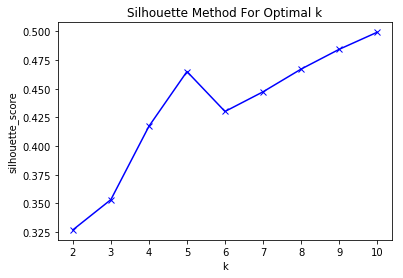

In [46]:
plt.plot(K_sil, sil, 'bx-')
plt.xlabel('k')
plt.ylabel('silhouette_score')
plt.title('Silhouette Method For Optimal k')
plt.show()

Let's set the number of clusters = 5

In [47]:
# set number of clusters
kclusters = 5

# run k-means clustering
kmeans = KMeans(init="k-means++", n_clusters=kclusters, n_init=10).fit(tor_grouped_clustering)

print(Counter(kmeans.labels_))

Counter({1: 82, 2: 30, 0: 26, 3: 19, 4: 13})


Next, create a new dataframe that includes the cluster as well as the top 5 venues for each neighborhood.

In [48]:
# add clustering labels
try:
    neighborhoods_venues_sorted.drop('Cluster Labels', axis=1)
except:
    neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

In [49]:
neighborhoods_venues_sorted.head(5)

,Cluster Labels,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,1,Adelaide,Farmers Market,Supermarket,Mosque,Halal Restaurant,Fish Market
1,4,Agincourt,Supermarket,Fruit & Vegetable Store,Mosque,Halal Restaurant,Fish Market
2,0,Agincourt North,Supermarket,Mosque,Halal Restaurant,Fruit & Vegetable Store,Fish Market
3,0,Bathurst Manor,Mosque,Supermarket,Halal Restaurant,Fruit & Vegetable Store,Fish Market
4,1,Bathurst Quay,Farmers Market,Supermarket,Fruit & Vegetable Store,Mosque,Halal Restaurant


In [50]:
# merge neighborhoods_venues_sorted withtor_data to add latitude/longitude for each neighborhood
tor_merged = neighborhoods_venues_sorted.join(toronto_data.set_index('Neighborhood'), on='Neighborhood')
tor_merged.head()

,Cluster Labels,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,Borough,Latitude,Longitude
0,1,Adelaide,Farmers Market,Supermarket,Mosque,Halal Restaurant,Fish Market,Downtown Toronto,43.650486,-79.379498
1,4,Agincourt,Supermarket,Fruit & Vegetable Store,Mosque,Halal Restaurant,Fish Market,Scarborough,43.785353,-79.278549
2,0,Agincourt North,Supermarket,Mosque,Halal Restaurant,Fruit & Vegetable Store,Fish Market,Scarborough,43.808038,-79.266439
3,0,Bathurst Manor,Mosque,Supermarket,Halal Restaurant,Fruit & Vegetable Store,Fish Market,North York,43.763893,-79.456367
4,1,Bathurst Quay,Farmers Market,Supermarket,Fruit & Vegetable Store,Mosque,Halal Restaurant,Downtown Toronto,43.635790,-79.398329


#### Visualise the clusters

In [51]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=10)

# set color scheme for the clusters
colors_array = cm.rainbow(np.linspace(0, 1, kclusters))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(tor_merged['Latitude'], tor_merged['Longitude'], tor_merged['Neighborhood'], tor_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

[Scroll back to Table of Contents](#toc)

## 5. Results <a name="results"></a>

In [52]:
required_column_indices = [2,3,7]
required_column = [list(tor_merged.columns.values)[i] for i in required_column_indices]

##### Cluster 0 - Red Cluster

In [53]:
cluster_0 = tor_merged.loc[tor_merged['Cluster Labels'] == 0, tor_merged.columns[1:12]]
cluster_0.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,Borough,Latitude,Longitude
2,Agincourt North,Supermarket,Mosque,Halal Restaurant,Fruit & Vegetable Store,Fish Market,Scarborough,43.808038,-79.266439
3,Bathurst Manor,Mosque,Supermarket,Halal Restaurant,Fruit & Vegetable Store,Fish Market,North York,43.763893,-79.456367
32,Downsview,Mosque,Supermarket,Halal Restaurant,Fruit & Vegetable Store,Fish Market,North York,43.749299,-79.462248
33,Downsview Central,Mosque,Supermarket,Halal Restaurant,Fruit & Vegetable Store,Fish Market,North York,43.749299,-79.462248
34,Downsview East,Mosque,Supermarket,Halal Restaurant,Fruit & Vegetable Store,Fish Market,North York,43.749299,-79.462248


In [54]:
for col in required_column:
    print(cluster_0[col].value_counts(ascending = False))
    print("---------------------------------------------")

Mosque         23
Supermarket     3
Name: 1st Most Common Venue, dtype: int64
---------------------------------------------
Supermarket         21
Mosque               3
Halal Restaurant     2
Name: 2nd Most Common Venue, dtype: int64
---------------------------------------------
North York         11
Scarborough        10
Etobicoke           3
Central Toronto     1
East York           1
Name: Borough, dtype: int64
---------------------------------------------


##### Cluster 1 - Blue Cluster

In [55]:
cluster_1 = tor_merged.loc[tor_merged['Cluster Labels'] == 1, tor_merged.columns[1:12]]
cluster_1.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,Borough,Latitude,Longitude
0,Adelaide,Farmers Market,Supermarket,Mosque,Halal Restaurant,Fish Market,Downtown Toronto,43.650486,-79.379498
4,Bathurst Quay,Farmers Market,Supermarket,Fruit & Vegetable Store,Mosque,Halal Restaurant,Downtown Toronto,43.635790,-79.398329
7,Berczy Park,Farmers Market,Supermarket,Mosque,Halal Restaurant,Fish Market,Downtown Toronto,43.647984,-79.375396
8,Birch Cliff,Mosque,Farmers Market,Supermarket,Halal Restaurant,Fruit & Vegetable Store,Scarborough,43.702112,-79.260091
10,Brockton,Farmers Market,Fish Market,Supermarket,Mosque,Halal Restaurant,West Toronto,43.650917,-79.440022


In [56]:
for col in required_column:
    print(cluster_1[col].value_counts(ascending = False))
    print("---------------------------------------------")

Farmers Market             54
Supermarket                16
Mosque                      5
Halal Restaurant            4
Fish Market                 3
Fruit & Vegetable Store     1
Name: 1st Most Common Venue, dtype: int64
---------------------------------------------
Supermarket                47
Farmers Market             15
Fish Market                 7
Fruit & Vegetable Store     6
Mosque                      5
Halal Restaurant            3
Name: 2nd Most Common Venue, dtype: int64
---------------------------------------------
Downtown Toronto    32
Etobicoke           14
Central Toronto     10
West Toronto         8
North York           7
Scarborough          6
East Toronto         4
York                 1
East York            1
Name: Borough, dtype: int64
---------------------------------------------


##### Cluster 2 - Light Blue Cluster

In [57]:
cluster_2 = tor_merged.loc[tor_merged['Cluster Labels'] == 2, tor_merged.columns[1:12]]
cluster_2.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,Borough,Latitude,Longitude
9,Bloordale Gardens,Supermarket,Farmers Market,Mosque,Halal Restaurant,Fruit & Vegetable Store,Etobicoke,43.635317,-79.563674
13,Cedarbrae,Supermarket,Mosque,Halal Restaurant,Fruit & Vegetable Store,Fish Market,Scarborough,43.756467,-79.226692
22,Cloverdale,Supermarket,Mosque,Halal Restaurant,Fruit & Vegetable Store,Fish Market,Etobicoke,43.633637,-79.549745
24,Davisville,Supermarket,Fruit & Vegetable Store,Fish Market,Farmers Market,Mosque,Central Toronto,43.697936,-79.397291
25,Davisville North,Supermarket,Fruit & Vegetable Store,Fish Market,Farmers Market,Mosque,Central Toronto,43.697936,-79.397291


In [58]:
for col in required_column:
    print(cluster_2[col].value_counts(ascending = False))
    print("---------------------------------------------")

Supermarket    30
Name: 1st Most Common Venue, dtype: int64
---------------------------------------------
Mosque                     20
Farmers Market              4
Fruit & Vegetable Store     3
Halal Restaurant            3
Name: 2nd Most Common Venue, dtype: int64
---------------------------------------------
Etobicoke          9
Scarborough        9
North York         8
West Toronto       2
Central Toronto    2
Name: Borough, dtype: int64
---------------------------------------------


##### Cluster 3 - Light Green Cluster

In [59]:
cluster_3 = tor_merged.loc[tor_merged['Cluster Labels'] == 3, tor_merged.columns[1:12]]
cluster_3.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,Borough,Latitude,Longitude
5,Bayview Village,Supermarket,Fish Market,Mosque,Halal Restaurant,Fruit & Vegetable Store,North York,43.769197,-79.376662
18,Clairlea,Fish Market,Supermarket,Mosque,Halal Restaurant,Fruit & Vegetable Store,Scarborough,43.708823,-79.295986
19,Clarks Corners,Fish Market,Mosque,Supermarket,Halal Restaurant,Fruit & Vegetable Store,Scarborough,43.796410,-79.297795
26,Deer Park,Supermarket,Fish Market,Mosque,Halal Restaurant,Fruit & Vegetable Store,Central Toronto,43.688090,-79.394093
30,Dorset Park,Supermarket,Mosque,Fish Market,Halal Restaurant,Fruit & Vegetable Store,Scarborough,43.752847,-79.282067


In [60]:
for col in required_column:
    print(cluster_3[col].value_counts(ascending = False))
    print("---------------------------------------------")

Fish Market    11
Supermarket     8
Name: 1st Most Common Venue, dtype: int64
---------------------------------------------
Supermarket    10
Fish Market     7
Mosque          2
Name: 2nd Most Common Venue, dtype: int64
---------------------------------------------
Scarborough         6
North York          3
York                2
Etobicoke           2
Central Toronto     2
East York           2
Downtown Toronto    1
West Toronto        1
Name: Borough, dtype: int64
---------------------------------------------


##### Cluster 4 - Orange Cluster

In [61]:
cluster_4 = tor_merged.loc[tor_merged['Cluster Labels'] == 4, tor_merged.columns[1:12]]
cluster_4.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,Borough,Latitude,Longitude
1,Agincourt,Supermarket,Fruit & Vegetable Store,Mosque,Halal Restaurant,Fish Market,Scarborough,43.785353,-79.278549
6,Bedford Park,Fruit & Vegetable Store,Supermarket,Mosque,Halal Restaurant,Fish Market,North York,43.737388,-79.410925
64,Keelesdale,Fruit & Vegetable Store,Supermarket,Mosque,Halal Restaurant,Fish Market,York,43.690158,-79.474998
69,King's Mill Park,Fruit & Vegetable Store,Fish Market,Supermarket,Mosque,Halal Restaurant,Etobicoke,43.651089,-79.492029
78,Lawrence Park,Fruit & Vegetable Store,Supermarket,Farmers Market,Mosque,Halal Restaurant,Central Toronto,43.729199,-79.403252


In [62]:
for col in required_column:
    print(cluster_4[col].value_counts(ascending = False))
    print("---------------------------------------------")

Fruit & Vegetable Store    12
Supermarket                 1
Name: 1st Most Common Venue, dtype: int64
---------------------------------------------
Supermarket                6
Fish Market                4
Mosque                     2
Fruit & Vegetable Store    1
Name: 2nd Most Common Venue, dtype: int64
---------------------------------------------
York               3
Etobicoke          3
East Toronto       2
West Toronto       2
Scarborough        1
Central Toronto    1
North York         1
Name: Borough, dtype: int64
---------------------------------------------


[Scroll back to Table of Contents](#toc)

## 6. Discussion <a name="discussion"></a>

To understand the clusters segmentation, three analysis were done on every cluster as follows:

1.	Count of 1st most common venue 
2.	Count of 2nd most common venue
3.	Count of Borough

These data interpret the property of clusters based on the similarities between the neighbourhoods within its cluster.

Table below summarise the k-Mean unsupervised machine learning technique results:

|         | Count of occurences within the cluster |                       |                                    |
|:---------:|:--------------------------------------:|:-----------------------:|:------------------------------------:|
| Cluster |          1st Most Common Venue         | 2nd Most Common Venue |               Borough              |
|    0    |         Fruit & Vegetable Store        |      Supermarket      |           York, Etobicoke          |
|    1    |             Farmers Market             |      Supermarket      |          Downtown Toronto          |
|    2    |               Fish Market              |      Supermarket      |             Scarborough            |
|    3    |               Supermarket              |         Mosque        | Scarborough, Etobicoke, North York |
|    4    |                 Mosque                 |      Supermarket      |       North York, Scarborough      |

From the analysis, it is obvious that Supermarket is the most common venue across all the clusters which also means across all neighbourhoods. From all 6 unique venue categories that were focused on for this project, Halal Restaurant appears to be an unpopular or less common venue around the neighbourhoods.

Following defined the clusters segmented by k-Means unsupervised machine learning technique:

    •	Cluster 0 – Fruit & Vegetable Store
    •	Cluster 1 – Farmers Market
    •	Cluster 2 – Fish Market
    •	Cluster 3 – Supermarket
    •	Cluster 4 – Mosque
    


[Scroll back to Table of Contents](#toc)

## 7. Conclusion <a name="conclusion"></a>

In conclusion, Toronto neighbourhoods were explored to analyse the best location for setting up a new restaurant that strictly focus on catering halal menu option. Mosque, Halal Restaurant, Fish Market, Farmers Market, Fruit & Vegetable Store and Supermarket venue categories were used to study the environment of each neighbourhood. These specific venue categories are some of the main keys in helping business owners in a number of ways. For example, where targeted audience are most saturated at, area with less competition and plenty of venues to get business supplies easily.

As a result, the best location to set up a new halal restaurant in general would be in Scarborough, Etobicoke and North York borough. It is highly recommended to select neighbourhoods from the cluster 3 and/or 4 of these boroughs. The mosque and the different types of market venues met the condition set in deciding the best location for this case. And for competition from other halal restaurants, it is not much of a concern as from the analysis done shows that halal restaurant is scarce.

Last but not least, the analysis performed in this project has some limitation. The accuracy of data depends on the data provided by Foursquare. The venues explored were only within 1km of the neighbourhoods and changing it can affect the clusters. The analysis scope can be expanded further to distinctly point out which neighbourhood would be the best location for the client to set up a halal restaurant.


[Scroll back to Table of Contents](#toc)

### Thank You.